In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_iris, load_diabetes
from typing import List

import joblib
from shapely import geometry
from shapely.geometry import MultiPoint
from pyispace.trace import trace_build_wrapper, trace, FootprintOutput

from matplotlib.ticker import StrMethodFormatter

In [3]:
import matplotlib as mpl

# Footprint dias_int

In [4]:
df_class = pd.read_csv(
     r"/home/files/Hospitalization/Hospitalization.csv"
)

df_mf = pd.read_csv(
    r"/home/files/Hospitalization/metadata.csv"
)

In [5]:
df_ih = pd.read_csv(
    r"/home/files/Hospitalization/ih.csv", 
    index_col='instances'
)
df_is = pd.read_csv(
    r"/home/files/Hospitalization/coordinates.csv", 
    index_col='Row'
)

In [6]:
def plot_poly(poly, c='blue'):
    if type(poly) == geometry.MultiPolygon:
        for p in poly.geoms:
            x,y = p.exterior.coords.xy
            _=plt.plot(x,y,c=c)
    else:
        x,y = poly.exterior.coords.xy
        _=plt.plot(x,y,c=c)

In [7]:
result = joblib.load(r"/home/files/Hospitalization/model.pkl")

In [8]:
T = []
t = 0.3

for i in range(0,10):
    T.append(round(t,2))
    t += 0.02

T.append(0.495)
T

[0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.495]

In [9]:
for t in T:
    bins=[0,t,round((1-t),2),1] 
    print(bins)


[0, 0.3, 0.7, 1]
[0, 0.32, 0.68, 1]
[0, 0.34, 0.66, 1]
[0, 0.36, 0.64, 1]
[0, 0.38, 0.62, 1]
[0, 0.4, 0.6, 1]
[0, 0.42, 0.58, 1]
[0, 0.44, 0.56, 1]
[0, 0.46, 0.54, 1]
[0, 0.48, 0.52, 1]
[0, 0.495, 0.51, 1]


0.3
FootprintOutput(polygon=<shapely.geometry.multipolygon.MultiPolygon object at 0x7f87de2fa490>, area=2.643709762591916, elements=701, good_elements=543, density=265.15769995596395, purity=0.7746077032810271)
0.32
FootprintOutput(polygon=<shapely.geometry.multipolygon.MultiPolygon object at 0x7f87d5c29940>, area=3.5552658117067306, elements=884, good_elements=770, density=248.64526221616873, purity=0.8710407239819005)
0.34
FootprintOutput(polygon=<shapely.geometry.multipolygon.MultiPolygon object at 0x7f87de2fa880>, area=4.156454629224862, elements=1080, good_elements=942, density=259.836831227822, purity=0.8722222222222222)
0.36
FootprintOutput(polygon=<shapely.geometry.multipolygon.MultiPolygon object at 0x7f87d5a9eb80>, area=6.021858694872822, elements=1810, good_elements=1522, density=300.57164933828227, purity=0.8408839779005525)
0.38
FootprintOutput(polygon=<shapely.geometry.polygon.Polygon object at 0x7f87de194f40>, area=8.022175639574709, elements=2458, good_elements=2167, de

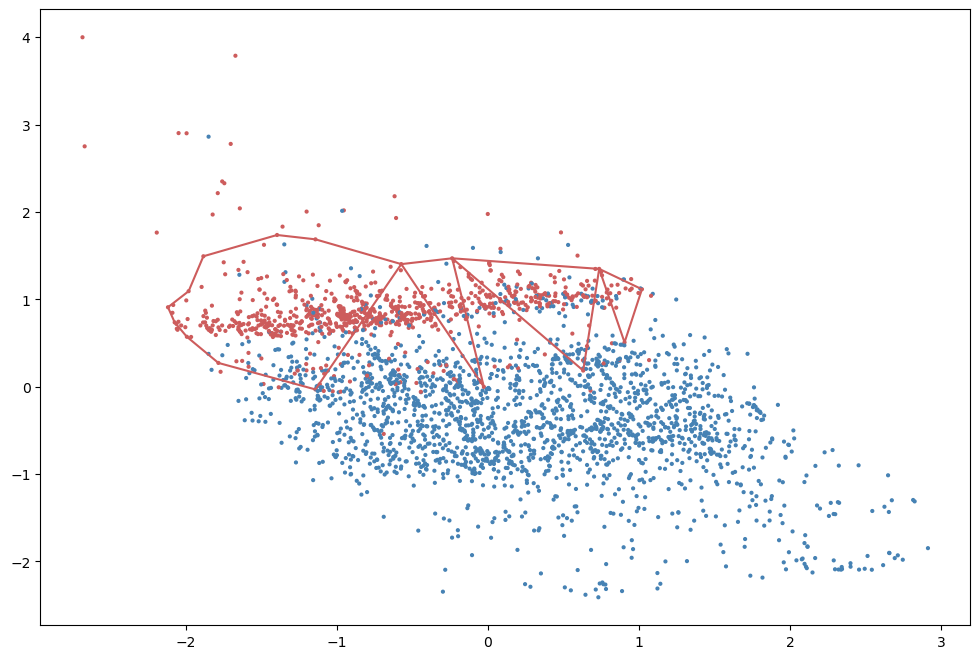

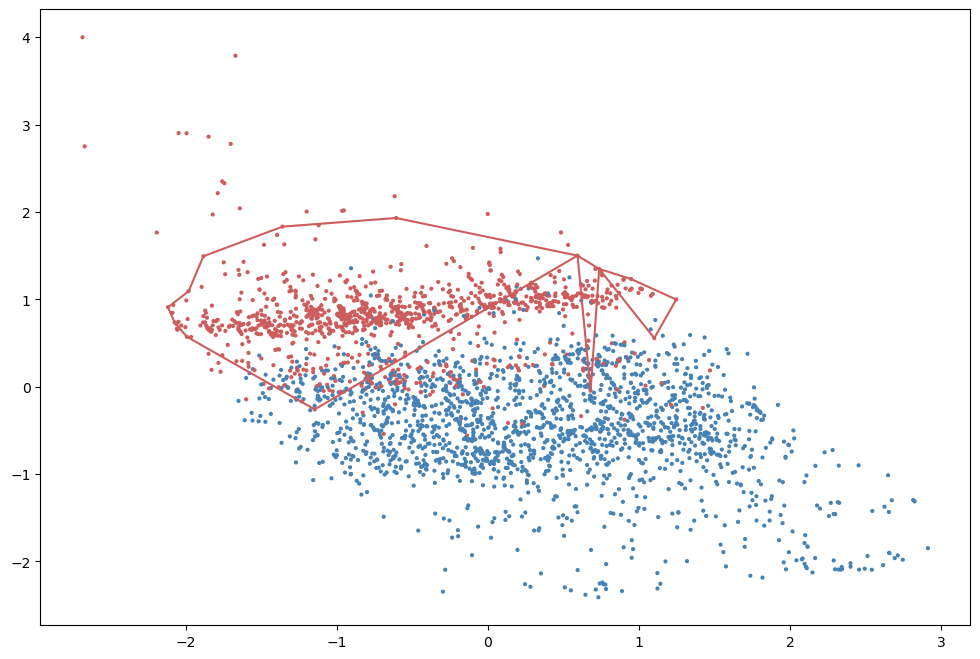

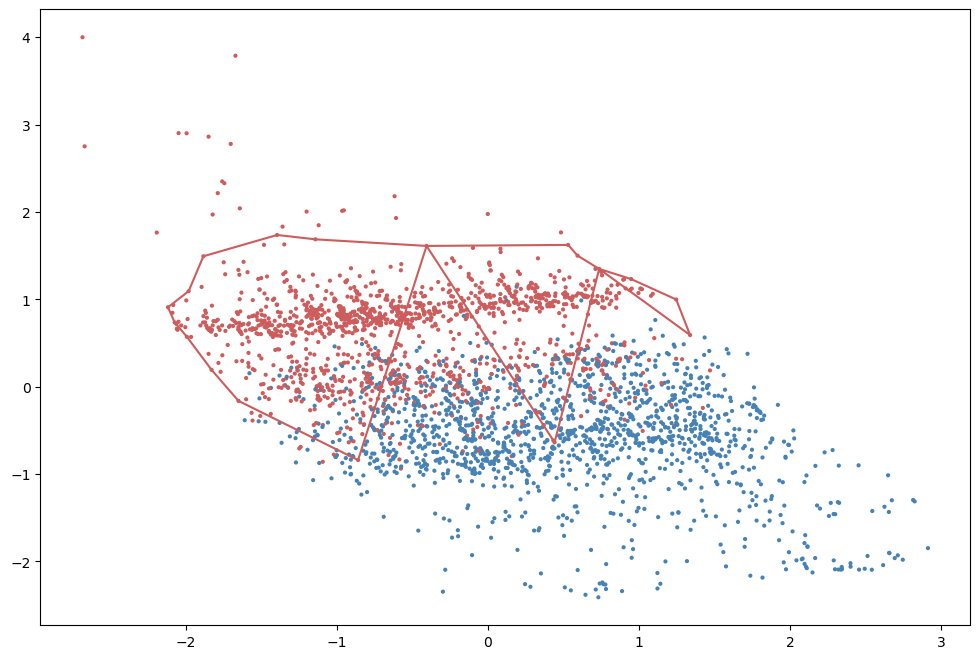

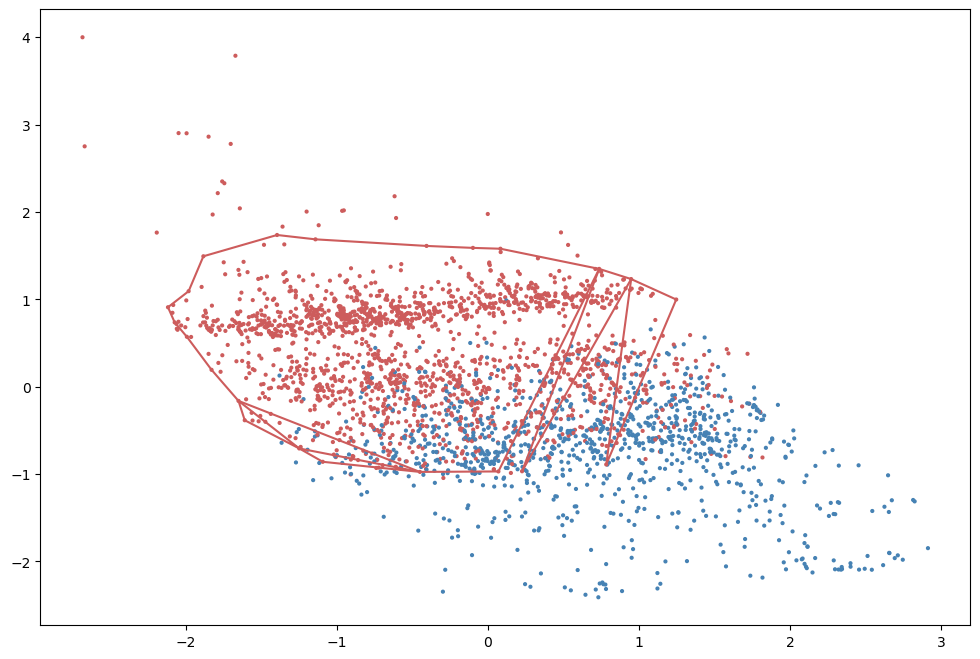

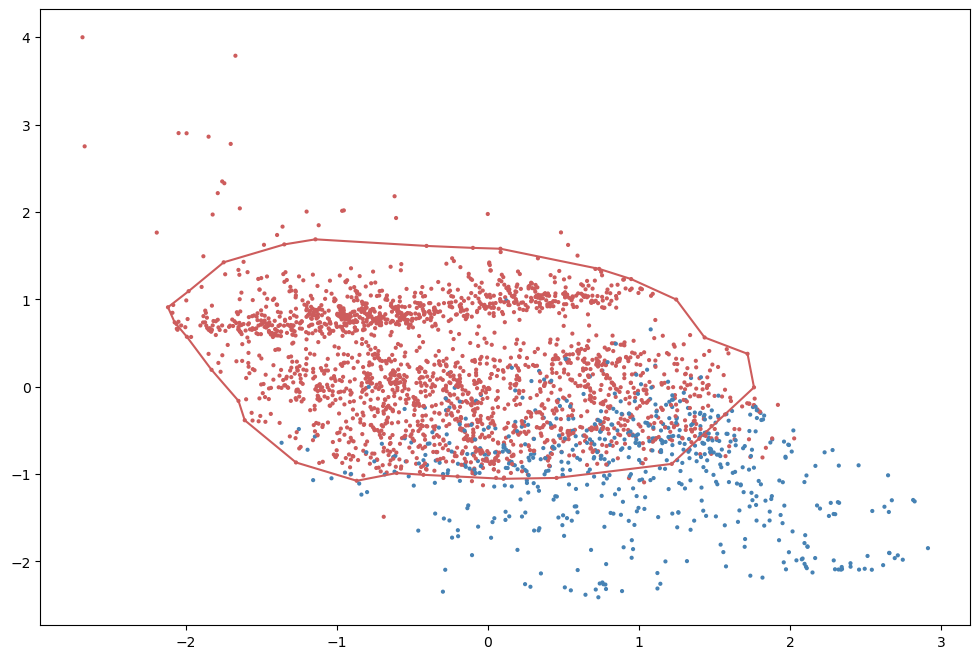

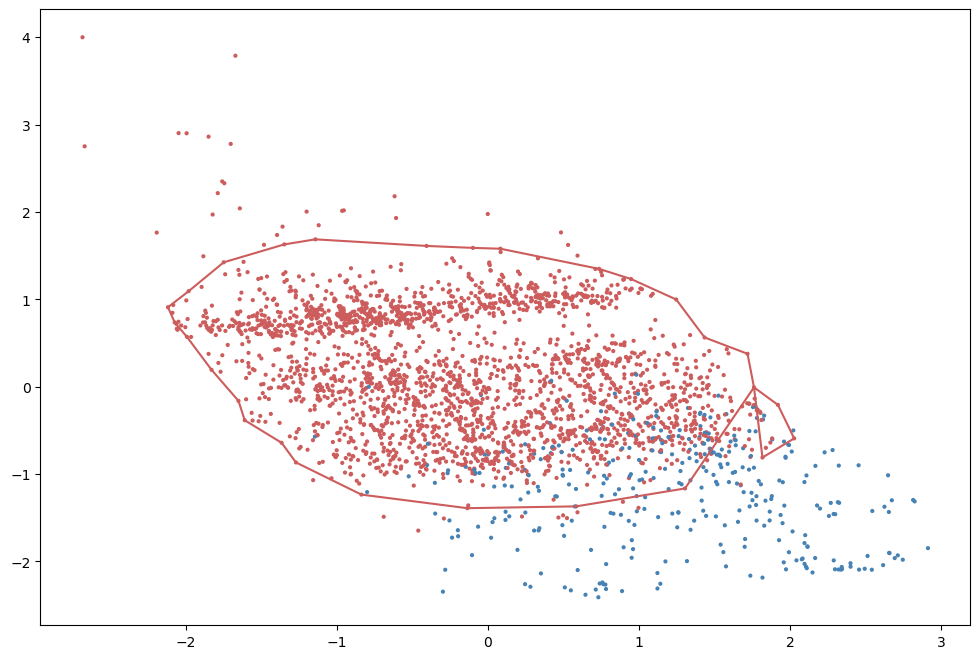

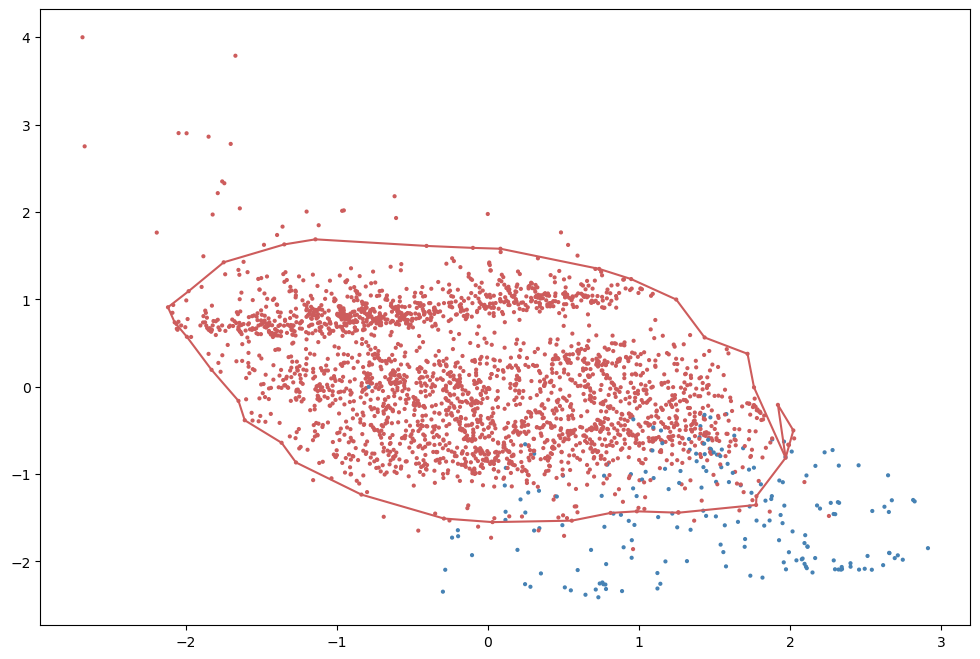

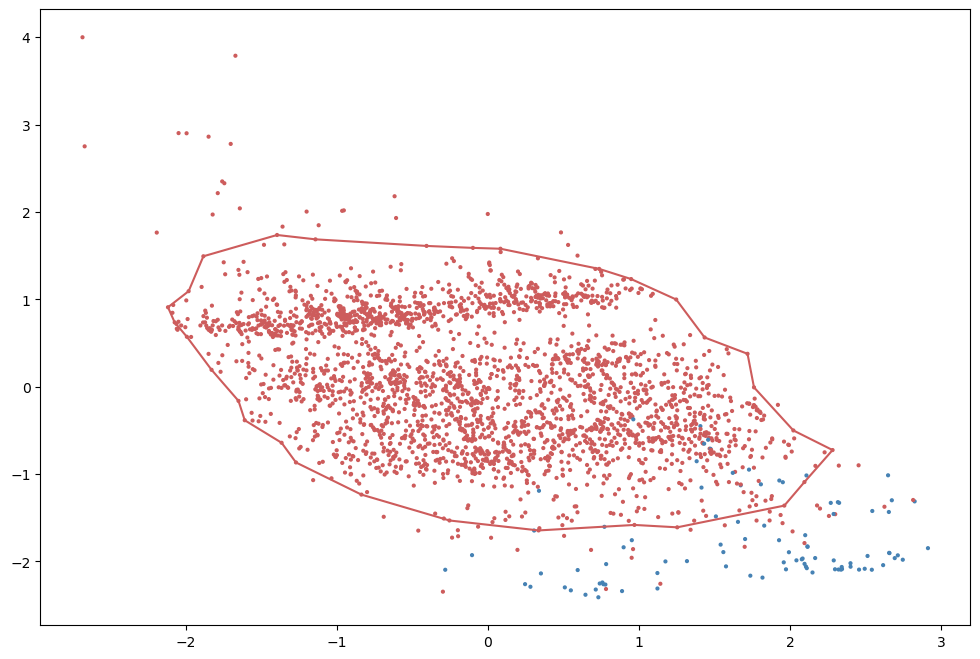

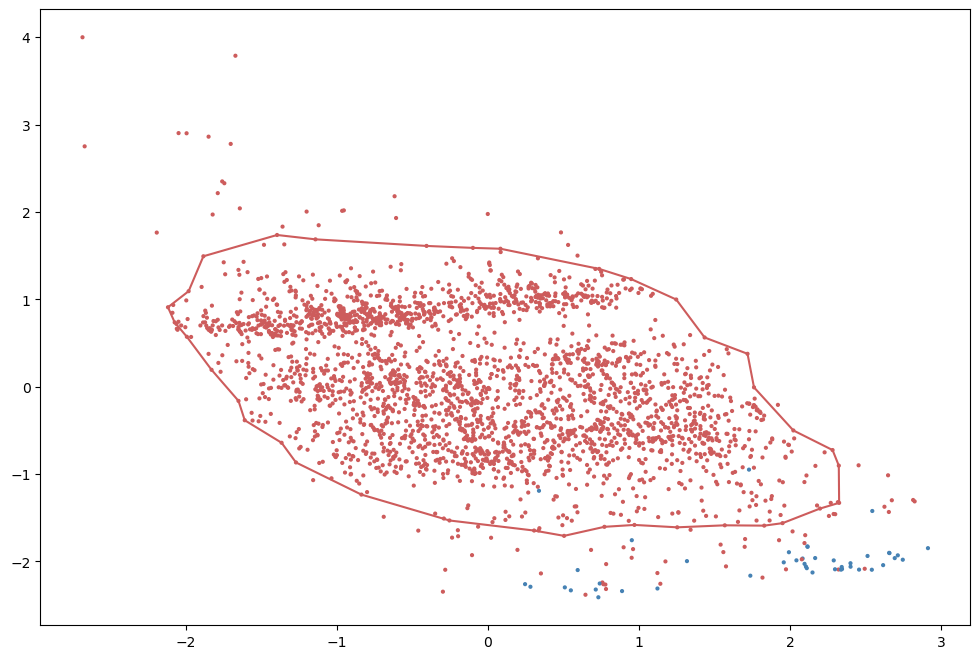

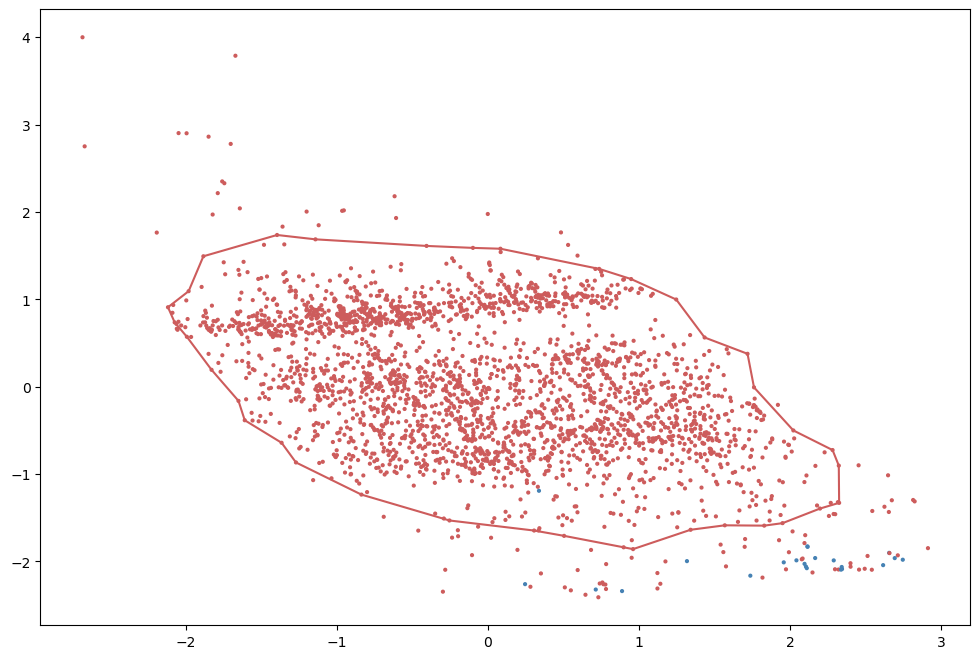

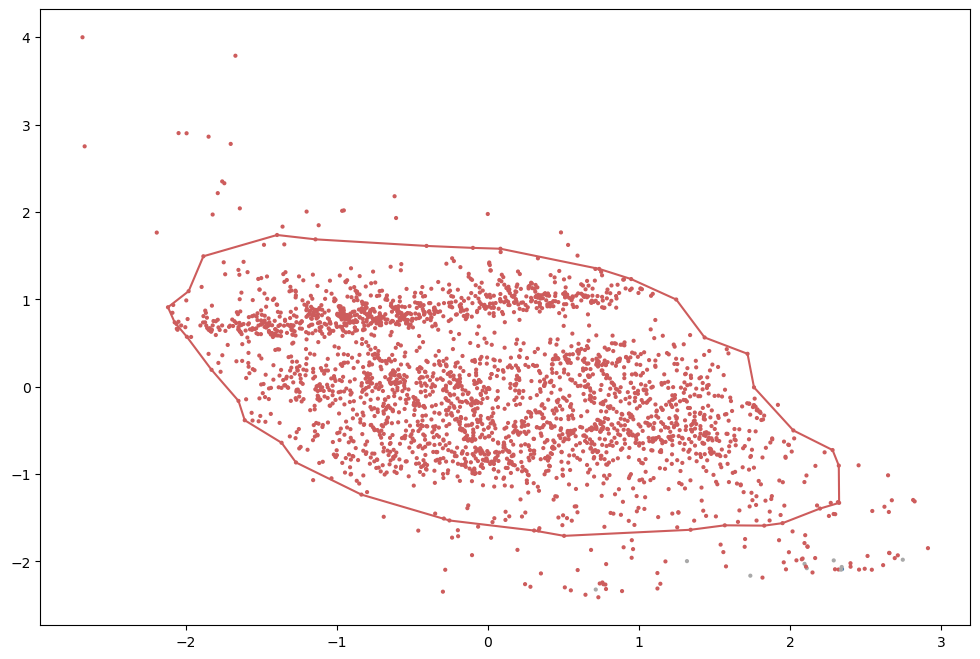

In [10]:
n = 1
fp_metrics = []
path = '/home/files/Hospitalization/'

for t in T:

    # define os cortes para facil, medio e dificil
    df_ih_tri = pd.cut(df_ih['instance_hardness'], bins=[0,t,(1-t),1], labels=[-1, 0, 1], include_lowest=True)

    # calcula os footprints
    pi = 0.55
    out_easy = trace_build_wrapper(result.pilot.Z, df_ih_tri.values == -1, pi)
    out_amb = trace_build_wrapper(result.pilot.Z, df_ih_tri.values == 0, pi)
    out_hard = trace_build_wrapper(result.pilot.Z, df_ih_tri.values == 1, pi)
    
    ninst = result.pilot.Z.shape[0]
    space = trace_build_wrapper(result.pilot.Z, np.ones(ninst, dtype=bool), pi)
    
    fp_metrics.append([t, out_easy.area/space.area, out_easy.density/space.density, out_easy.purity,
                   out_amb.area/space.area, out_amb.density/space.density, out_amb.purity,
                   out_hard.area/space.area, out_hard.density/space.density, out_hard.purity])
    
    print(t)
    cmap = ListedColormap(['steelblue', 'darkgray', 'indianred'])

    plt.figure(figsize=(12, 8))
    plt.scatter(*result.pilot.Z.T, c=df_ih_tri.values, s=4, cmap=cmap)
    plot_poly(out_easy.polygon, 'steelblue')
    #plot_poly(out_amb.polygon, 'green')
    plot_poly(out_hard.polygon, 'indianred')
    #plot_poly(space.polygon, 'black')

    poly = out_hard.polygon #.geoms[0]

    plt.savefig('dias_int' + str(t) + '.pdf', bbox_inches='tight')

    print(out_hard)


In [12]:
fp_metrics = pd.DataFrame(np.row_stack(fp_metrics))

fp_metrics.columns =['t','out_easy.area', 'out_easy.density', 'out_easy.purity', 
                  'out_amb.area', 'out_amb.density', 'out_amb.purity',
                  'out_hard.area', 'out_hard.density', 'out_hard.purity']

fp_metrics = round(fp_metrics, 3)
fp_metrics['harm_hard'] = ((fp_metrics['out_hard.area']) * (fp_metrics['out_hard.density']))
fp_metrics['geo_hard'] = np.sqrt(fp_metrics['harm_hard']*(fp_metrics['out_hard.purity']))

fp_metrics['harm_easy'] = (fp_metrics['out_easy.area']) * (fp_metrics['out_easy.density'])
fp_metrics['geo_easy'] = np.sqrt(fp_metrics['harm_easy']*(fp_metrics['out_easy.purity']))

fp_metrics['metric'] = (fp_metrics['out_hard.purity'] + fp_metrics['out_easy.purity'])/2
fp_metrics

t  out_easy.area  out_easy.density  out_easy.purity  out_amb.area  \
0   0.300            0.0               0.0              0.0         0.661   
1   0.320            0.0               0.0              0.0         0.625   
2   0.340            0.0               0.0              0.0         0.545   
3   0.360            0.0               0.0              0.0         0.371   
4   0.380            0.0               0.0              0.0         0.310   
5   0.400            0.0               0.0              0.0         0.176   
6   0.420            0.0               0.0              0.0         0.211   
7   0.440            0.0               0.0              0.0         0.116   
8   0.460            0.0               0.0              0.0         0.019   
9   0.480            0.0               0.0              0.0         0.008   
10  0.495            0.0               0.0              0.0         0.000   

    out_amb.density  out_amb.purity  out_hard.area  out_hard.density  \
0             0.995           0.954          0.246             1.047   
1             1.058           0.892          0.331             0.982   
2             1.079           0.816          0.387             1.026   
3             0.808           0.748          0.561             1.187   
4             0.424           0.765          0.747             1.210   
5             0.255           0.934          0.832             1.134   
6             0.213           0.828          0.900             1.086   
7             0.254           0.850          0.951             1.041   
8             0.687           0.914          0.974             1.023   
9             0.714           0.733          0.986             1.012   
10            0.000           0.000          0.979             1.018   

    out_hard.purity  harm_hard  geo_hard  harm_easy  geo_easy  metric  
0             0.775   0.257562  0.446778        0.0       0.0  0.3875  
1             0.871   0.325042  0.532082        0.0       0.0  0.4355  
2             0.872   0.397062  0.588420        0.0       0.0  0.4360  
3             0.841   0.665907  0.748350        0.0       0.0  0.4205  
4             0.882   0.903870  0.892868        0.0       0.0  0.4410  
5             0.947   0.943488  0.945242        0.0       0.0  0.4735  
6             0.975   0.977400  0.976199        0.0       0.0  0.4875  
7             0.994   0.989991  0.991993        0.0       0.0  0.4970  
8             0.999   0.996402  0.997700        0.0       0.0  0.4995  
9             1.000   0.997832  0.998915        0.0       0.0  0.5000  
10            1.000   0.996622  0.998310        0.0       0.0  0.5000

In [13]:
df = fp_metrics[fp_metrics["out_hard.density"] > 0]
area_dias = list(df['out_hard.area'])
density_dias = df['out_hard.density']
purity_dias = list(df['out_hard.purity'])

area_easy_dias = list(df['out_easy.area'])
density_easy_dias = df['out_easy.density']
purity_easy_dias = list(df['out_easy.purity'])


# Footprint gravidade

In [14]:
df_class = pd.read_csv(
     r"/home/files/severity/Severity.csv"
)

df_mf = pd.read_csv(
    r"/home/files/severity/Severity/metadata.csv"
)

In [15]:
df_ih = pd.read_csv(
    r"home/files/severity/Severity/ih.csv", 
    index_col='instances'
)
df_is = pd.read_csv(
    r"home/files/severity/Severity/coordinates.csv", 
    index_col='Row'
)

In [16]:
result = joblib.load(r"/home/files/severity/Severity/model.pkl")

0.3
FootprintOutput(polygon=<shapely.geometry.multipolygon.MultiPolygon object at 0x7f87de2dec70>, area=0.11031576989846634, elements=180, good_elements=164, density=1631.6796788498182, purity=0.9111111111111111)
0.32
FootprintOutput(polygon=<shapely.geometry.multipolygon.MultiPolygon object at 0x7f87d56e0400>, area=0.09519131547212699, elements=176, good_elements=163, density=1848.908160656049, purity=0.9261363636363636)
0.34
FootprintOutput(polygon=<shapely.geometry.polygon.Polygon object at 0x7f87d5898b20>, area=0.2350268808448305, elements=230, good_elements=198, density=978.6114642428951, purity=0.8608695652173913)
0.36
FootprintOutput(polygon=<shapely.geometry.polygon.Polygon object at 0x7f87d5898ee0>, area=0.2350268808448305, elements=230, good_elements=201, density=978.6114642428951, purity=0.8739130434782608)
0.38
FootprintOutput(polygon=<shapely.geometry.polygon.Polygon object at 0x7f87de1b7460>, area=0.25737208428619746, elements=225, good_elements=201, density=874.220685681

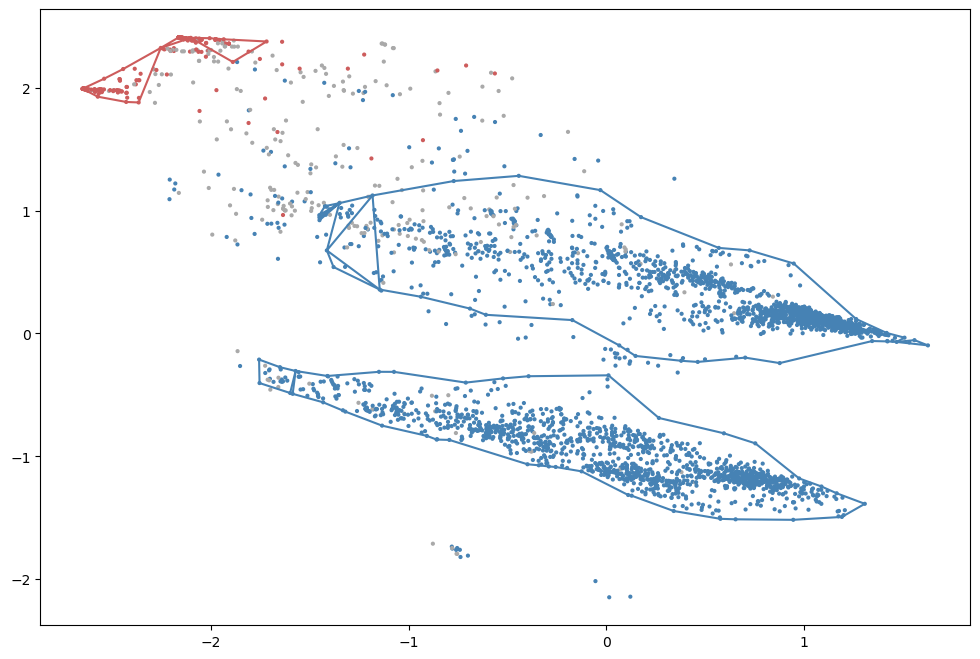

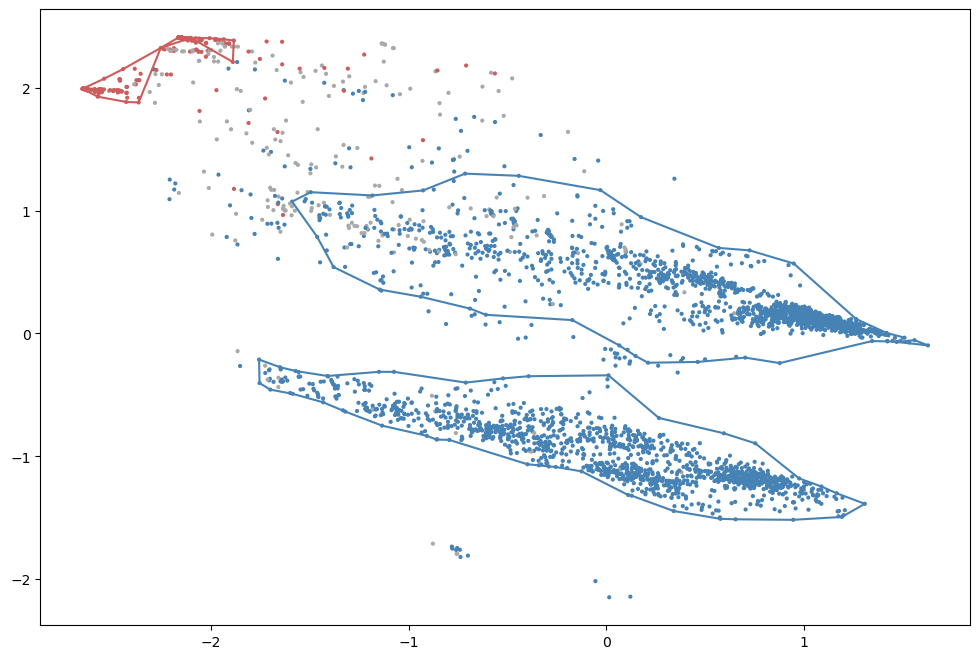

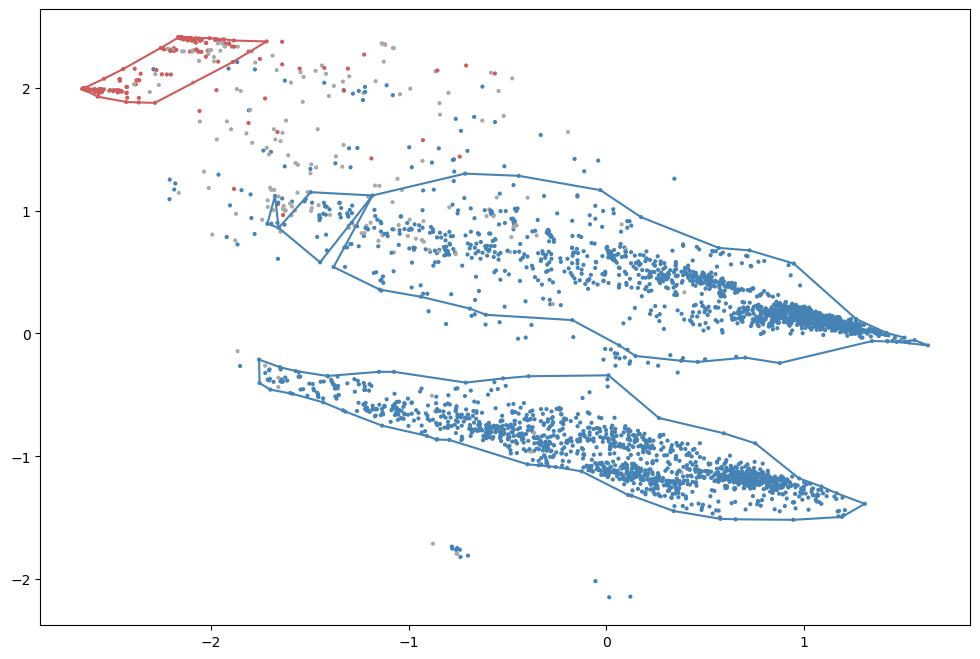

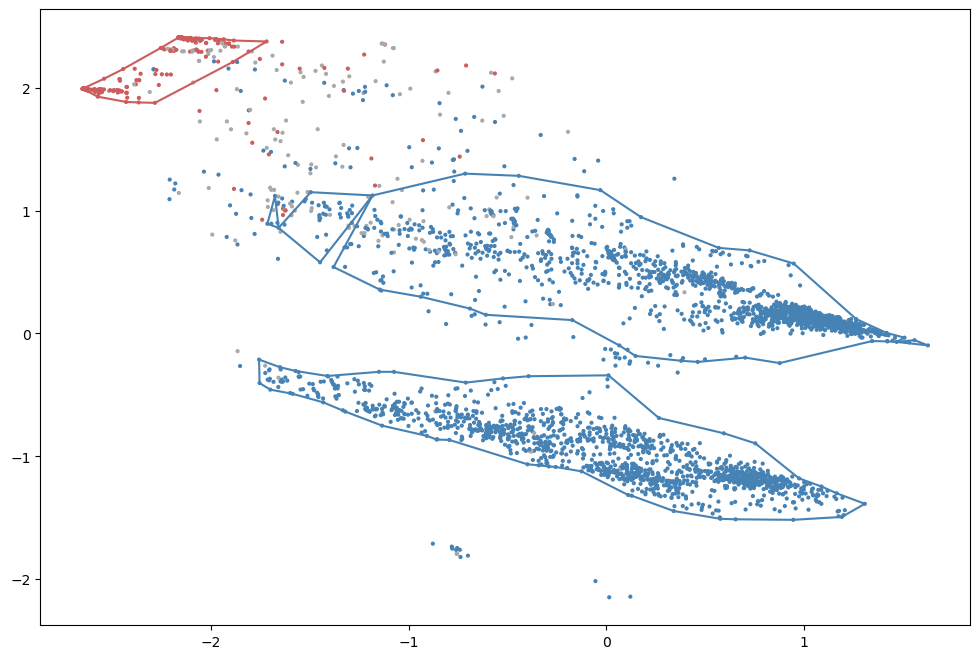

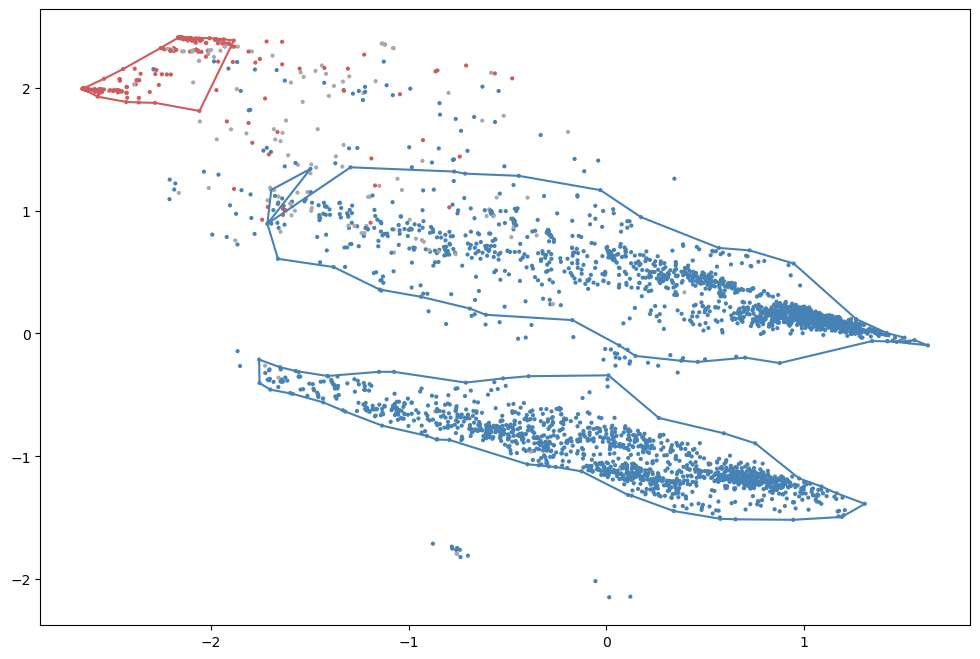

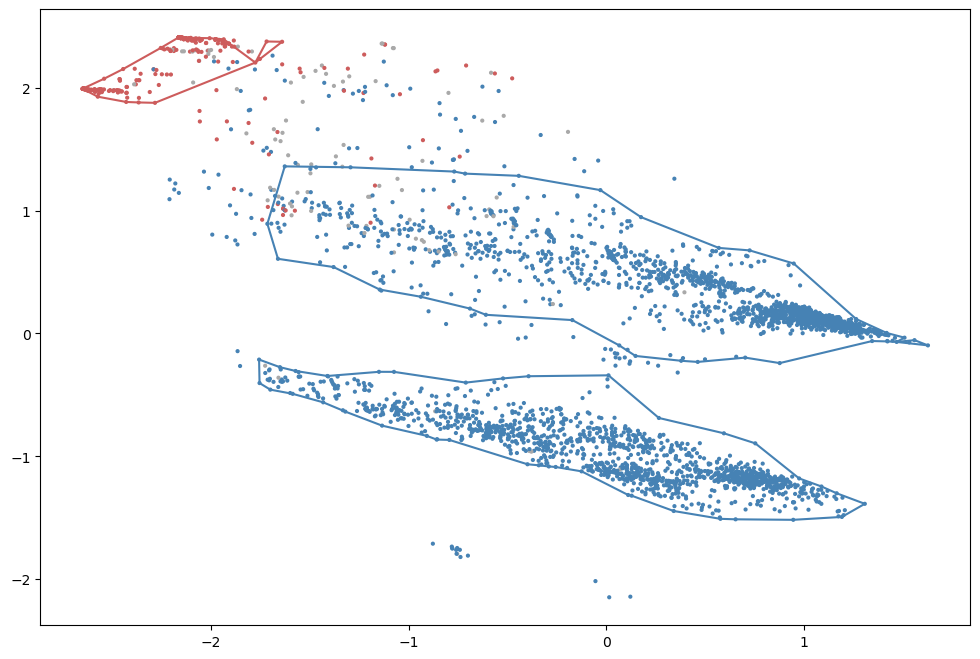

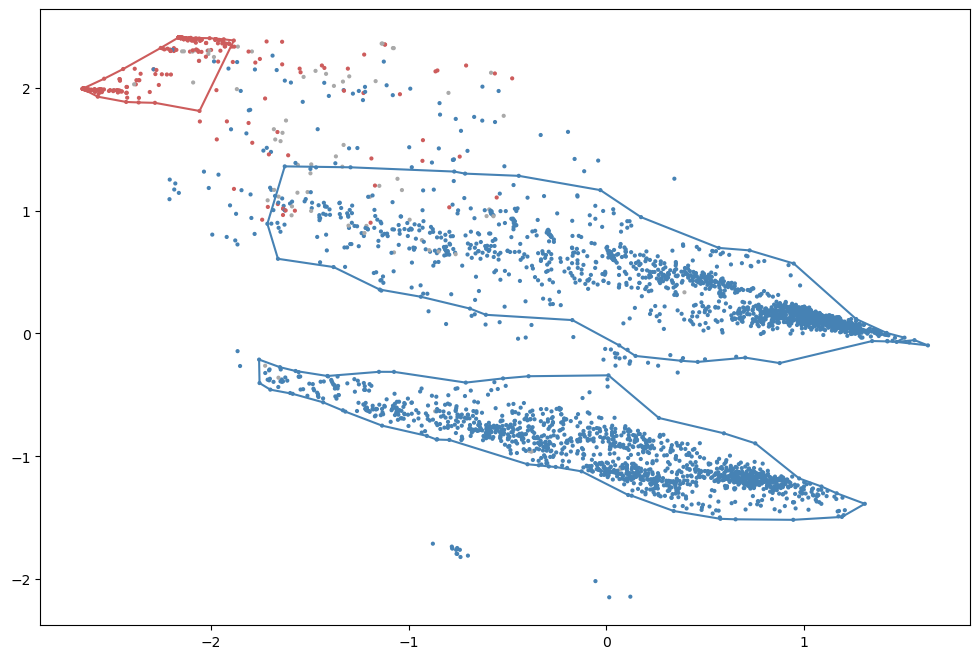

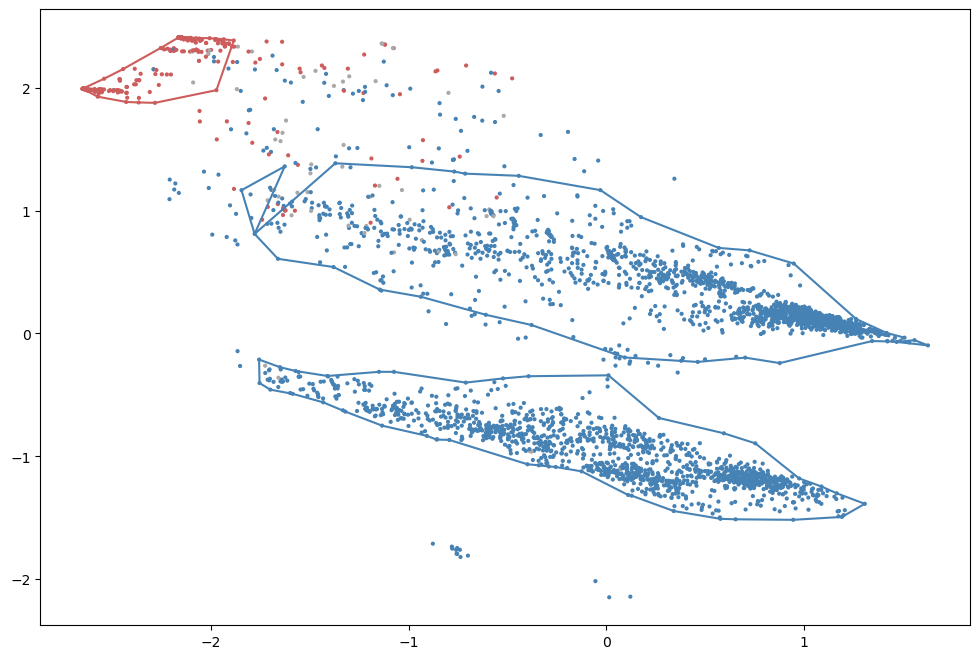

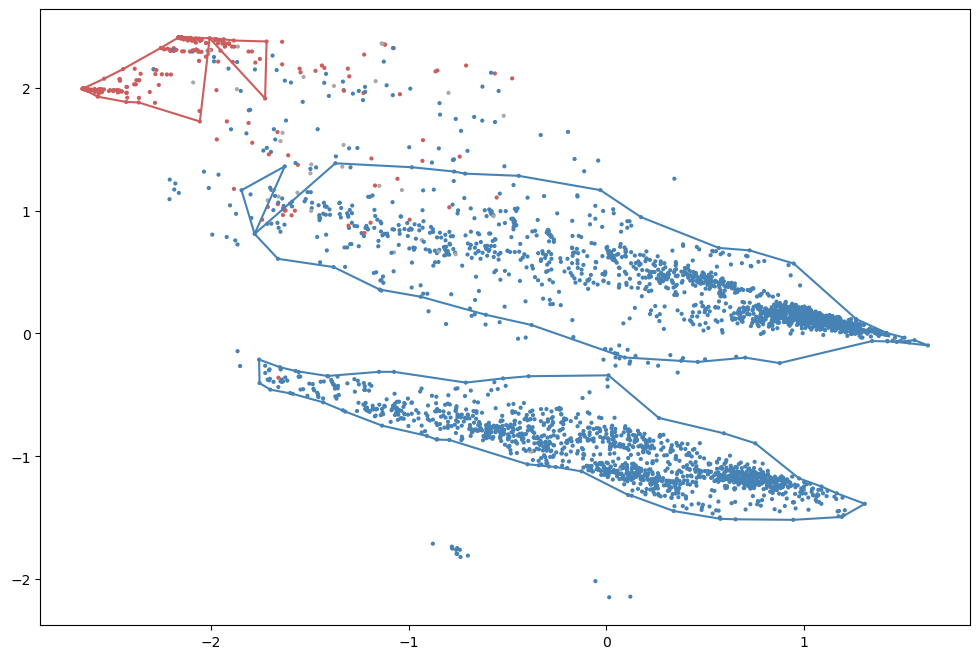

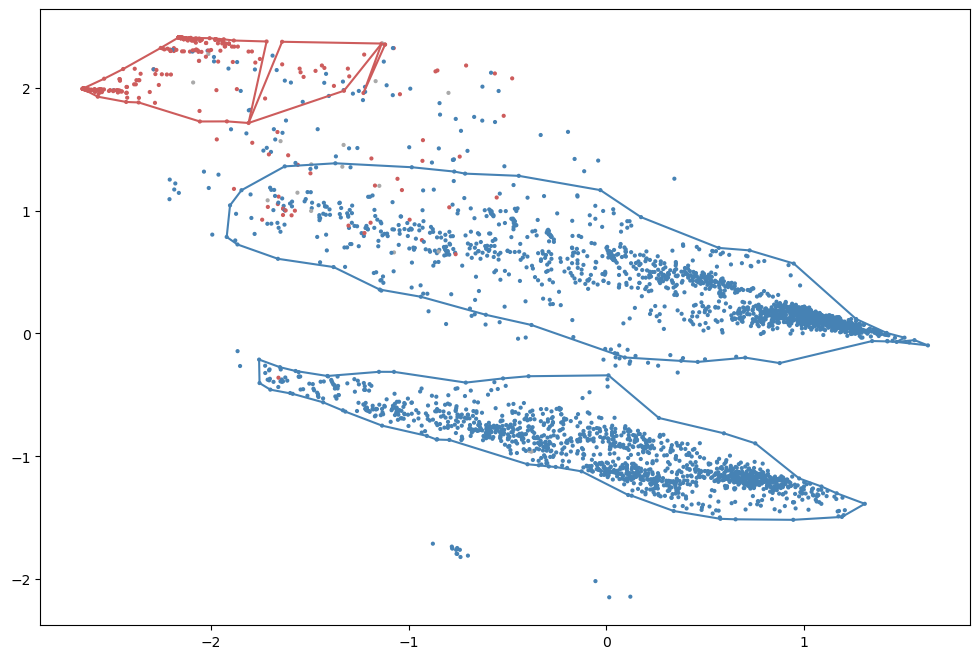

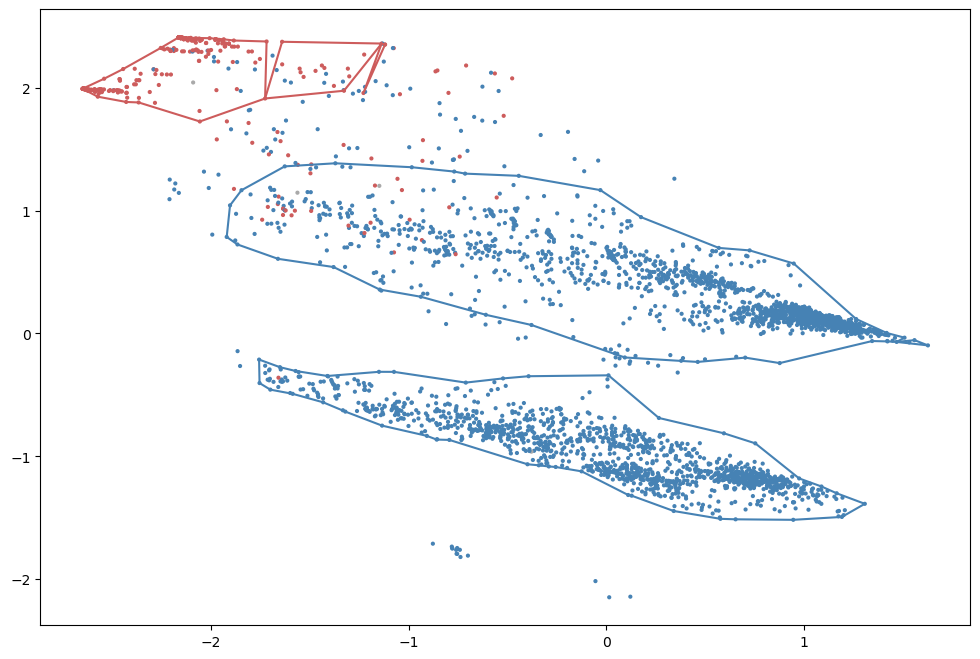

In [17]:
n = 1
fp_metrics = []
path = '/home/files/severity/Severity'

for t in T:

    df_ih_tri = pd.cut(df_ih['instance_hardness'], bins=[0,t,(1-t),1], labels=[-1, 0, 1], include_lowest=True)

    #finding footprints
    pi = 0.55
    out_easy = trace_build_wrapper(result.pilot.Z, df_ih_tri.values == -1, pi)
    out_amb = trace_build_wrapper(result.pilot.Z, df_ih_tri.values == 0, pi)
    out_hard = trace_build_wrapper(result.pilot.Z, df_ih_tri.values == 1, pi)
    
    ninst = result.pilot.Z.shape[0]
    space = trace_build_wrapper(result.pilot.Z, np.ones(ninst, dtype=bool), pi)
    
    fp_metrics.append([t, out_easy.area/space.area, out_easy.density/space.density, out_easy.purity,
                   out_amb.area/space.area, out_amb.density/space.density, out_amb.purity,
                   out_hard.area/space.area, out_hard.density/space.density, out_hard.purity])
    


    print(t)
    cmap = ListedColormap(['steelblue', 'darkgray', 'indianred'])

    plt.figure(figsize=(12, 8))
    plt.scatter(*result.pilot.Z.T, c=df_ih_tri.values, s=4, cmap=cmap)
    plot_poly(out_easy.polygon, 'steelblue')
    #plot_poly(out_amb.polygon, 'green')
    plot_poly(out_hard.polygon, 'indianred')
    #plot_poly(space.polygon, 'black')
    plt.savefig('gravidade' + str(t) + '.pdf', bbox_inches='tight')

    poly = out_hard.polygon #.geoms[0]

    print(out_hard)

In [19]:
fp_metrics = pd.DataFrame(np.row_stack(fp_metrics))

fp_metrics.columns =['t','out_easy.area', 'out_easy.density', 'out_easy.purity', 
                  'out_amb.area', 'out_amb.density', 'out_amb.purity',
                  'out_hard.area', 'out_hard.density', 'out_hard.purity']

fp_metrics = round(fp_metrics, 3)
fp_metrics['num'] = (fp_metrics['out_hard.area'] * fp_metrics['out_hard.density'])
fp_metrics['metric'] = (fp_metrics['out_hard.purity'] + fp_metrics['out_easy.purity'])/2
fp_metrics

t  out_easy.area  out_easy.density  out_easy.purity  out_amb.area  \
0   0.300          0.764             1.166            0.974         0.365   
1   0.320          0.798             1.130            0.975         0.145   
2   0.340          0.804             1.124            0.981         0.087   
3   0.360          0.804             1.124            0.984         0.032   
4   0.380          0.840             1.082            0.984         0.003   
5   0.400          0.850             1.073            0.985         0.000   
6   0.420          0.850             1.073            0.987         0.008   
7   0.440          0.866             1.056            0.989         0.000   
8   0.460          0.866             1.056            0.991         0.000   
9   0.480          0.889             1.035            0.990         0.000   
10  0.495          0.889             1.035            0.991         0.000   

    out_amb.density  out_amb.purity  out_hard.area  out_hard.density  \
0             0.187           0.636          0.021             2.575   
1             0.150           0.694          0.018             2.918   
2             0.202           0.655          0.045             1.545   
3             0.095           0.900          0.045             1.545   
4             0.473           1.000          0.050             1.380   
5             0.000           0.000          0.049             1.440   
6             0.484           0.846          0.050             1.380   
7             0.000           0.000          0.047             1.448   
8             0.000           0.000          0.059             1.191   
9             0.000           0.000          0.126             0.651   
10            0.000           0.000          0.116             0.696   

    out_hard.purity       num  metric  
0             0.911  0.054075  0.9425  
1             0.926  0.052524  0.9505  
2             0.861  0.069525  0.9210  
3             0.874  0.069525  0.9290  
4             0.893  0.069000  0.9385  
5             0.922  0.070560  0.9535  
6             0.933  0.069000  0.9600  
7             0.951  0.068056  0.9700  
8             0.957  0.070269  0.9740  
9             0.911  0.082026  0.9505  
10            0.929  0.080736  0.9600

In [22]:
df = fp_metrics[fp_metrics["out_hard.density"] > 0]
area_gravidade = list(df['out_hard.area'])
density_gravidade = df['out_hard.density']
purity_gravidade = list(df['out_hard.purity'])

area_easy_gravidade = list(df['out_easy.area'])
density_easy_gravidade = df['out_easy.density']
purity_easy_gravidade = list(df['out_easy.purity'])

# Footprint hospital 1

In [23]:
df_class = pd.read_csv(
     r"/home/files/hospital1/Hospital1.csv"
)

In [24]:
df_ih = pd.read_csv(
    r"/home/files/hospital1/ih.csv", 
    index_col='instances'
)

df_is = pd.read_csv(
    r"/home/files/hospital1/coordinates.csv", 
    index_col='Row'
)

df_mf = pd.read_csv(
    r"/home/files/hospital1/metadata.csv"
)

0.3
FootprintOutput(polygon=<shapely.geometry.polygon.Polygon object at 0x7f87d5abc2b0>, area=0.019896739974298402, elements=13, good_elements=9, density=653.3733675362265, purity=0.6923076923076923)
0.32
FootprintOutput(polygon=<shapely.geometry.polygon.Polygon object at 0x7f87d5c00370>, area=0.04835579522711752, elements=30, good_elements=21, density=620.4013367807516, purity=0.7)
0.34
FootprintOutput(polygon=<shapely.geometry.multipolygon.MultiPolygon object at 0x7f87d5593520>, area=0.07846447736733131, elements=38, good_elements=30, density=484.2955854036097, purity=0.7894736842105263)
0.36
FootprintOutput(polygon=<shapely.geometry.multipolygon.MultiPolygon object at 0x7f87d3d218e0>, area=0.2336396745290891, elements=85, good_elements=63, density=363.80807399822476, purity=0.7411764705882353)
0.38
FootprintOutput(polygon=<shapely.geometry.multipolygon.MultiPolygon object at 0x7f87d22fd190>, area=0.2597276930209721, elements=81, good_elements=63, density=311.86508861594336, purity=0

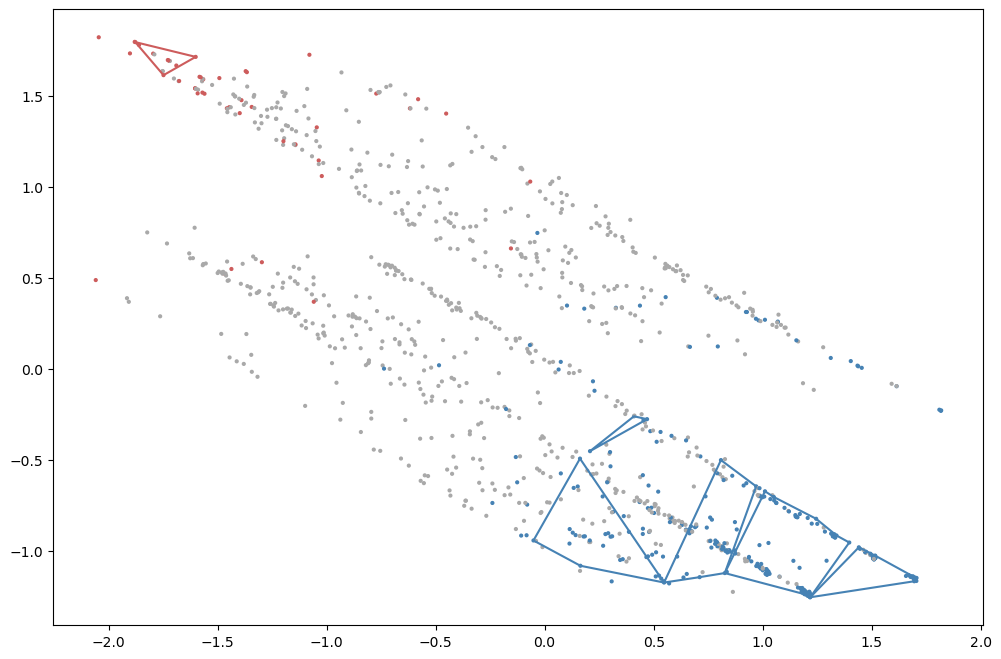

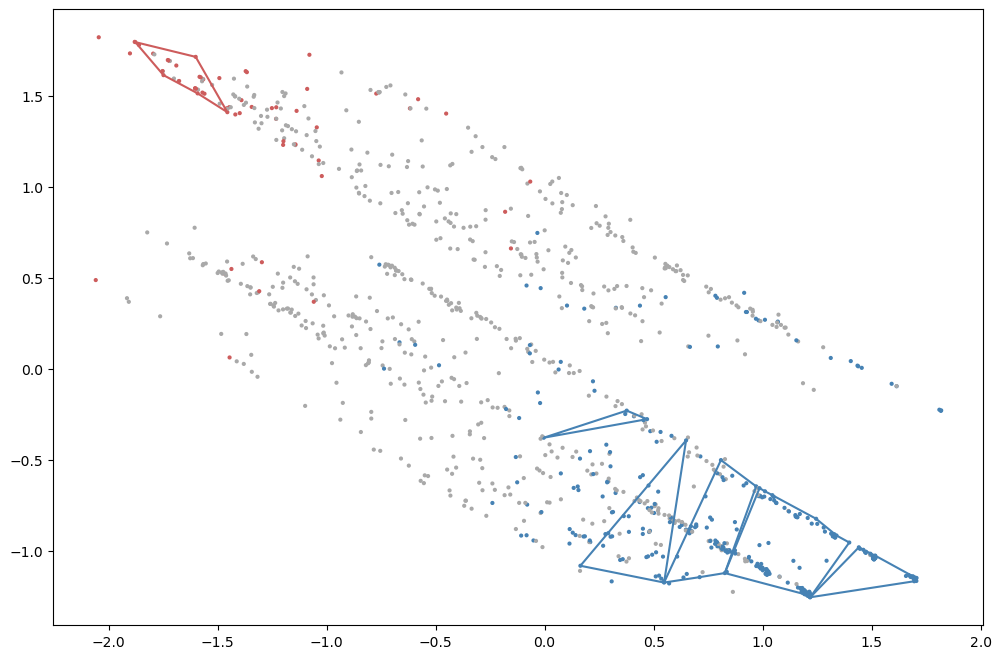

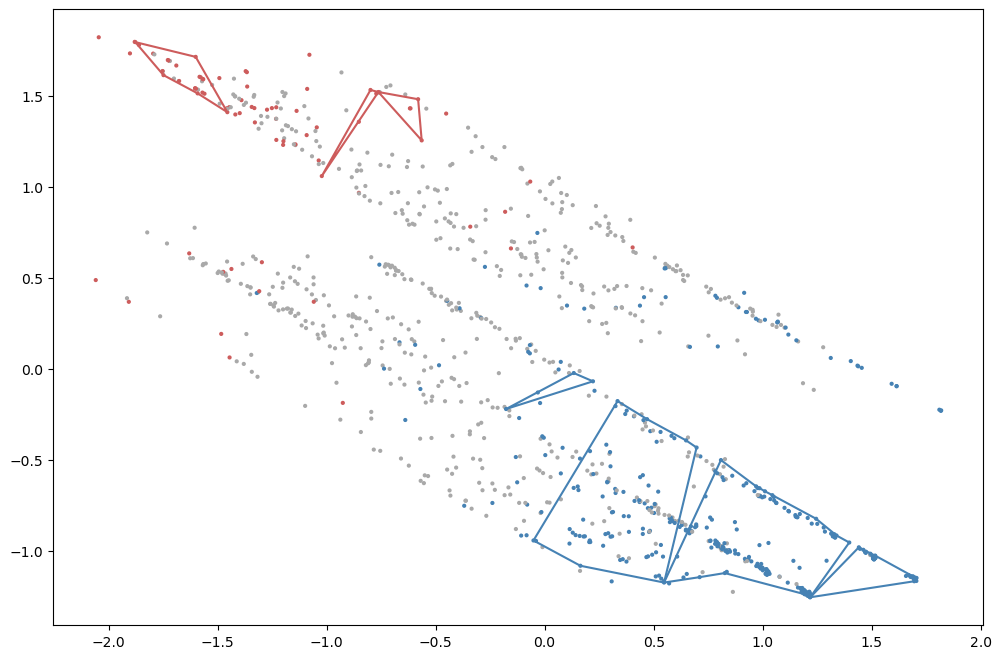

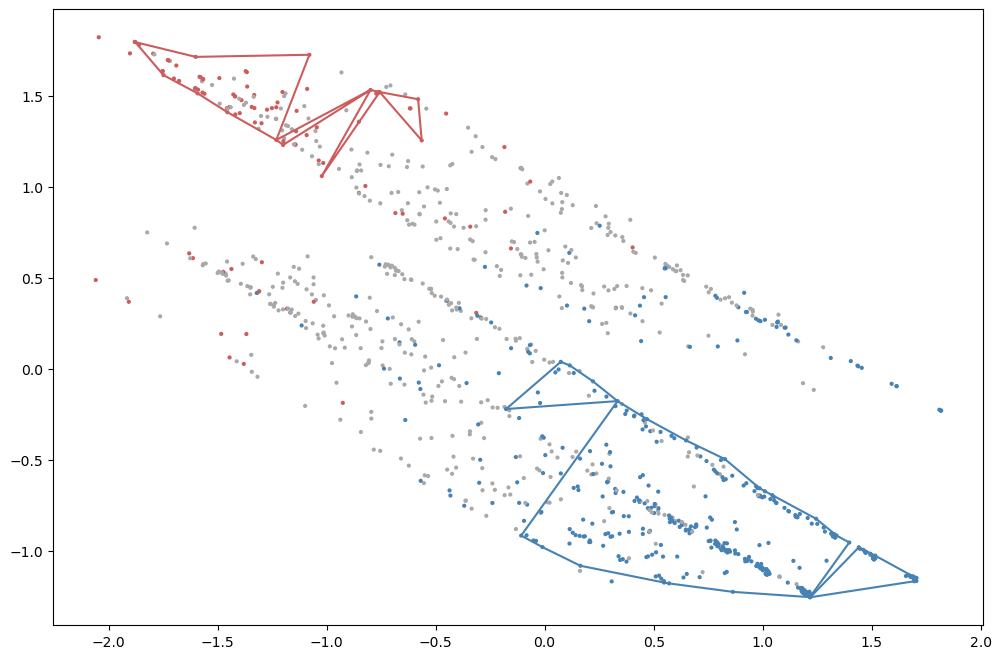

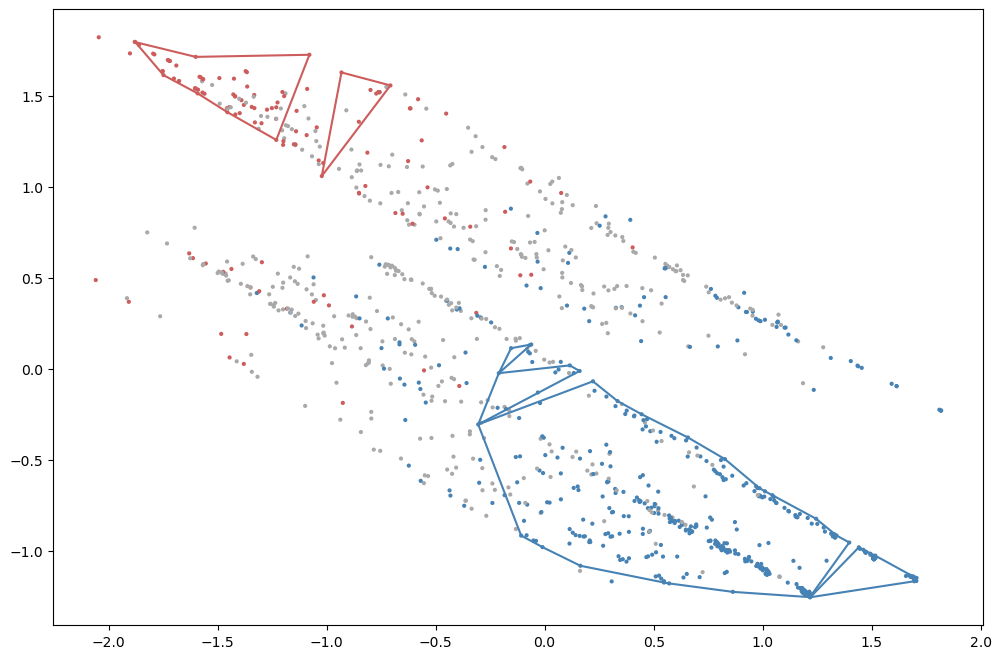

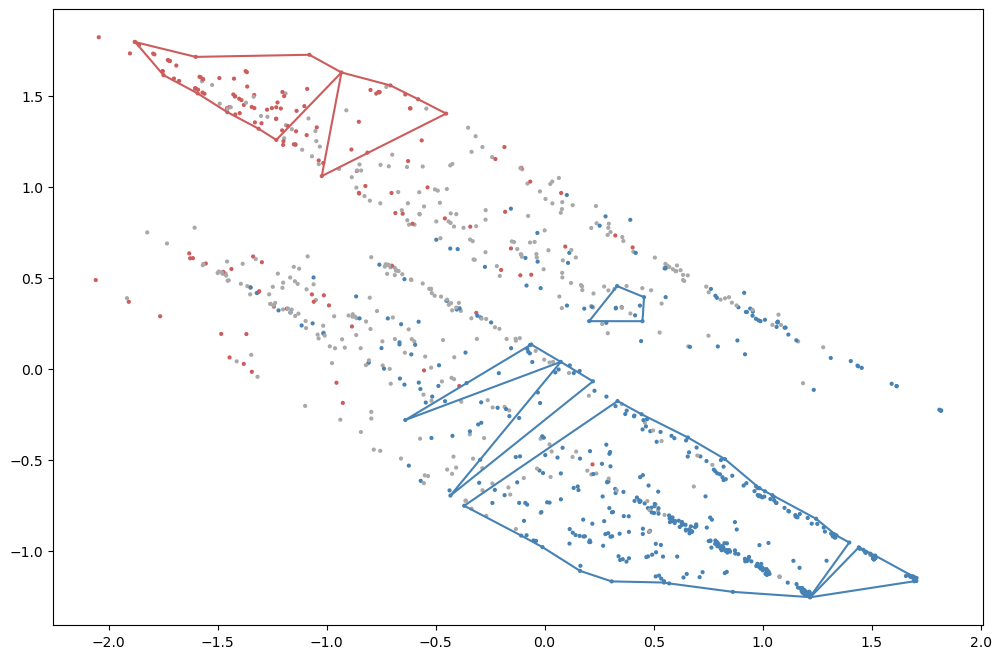

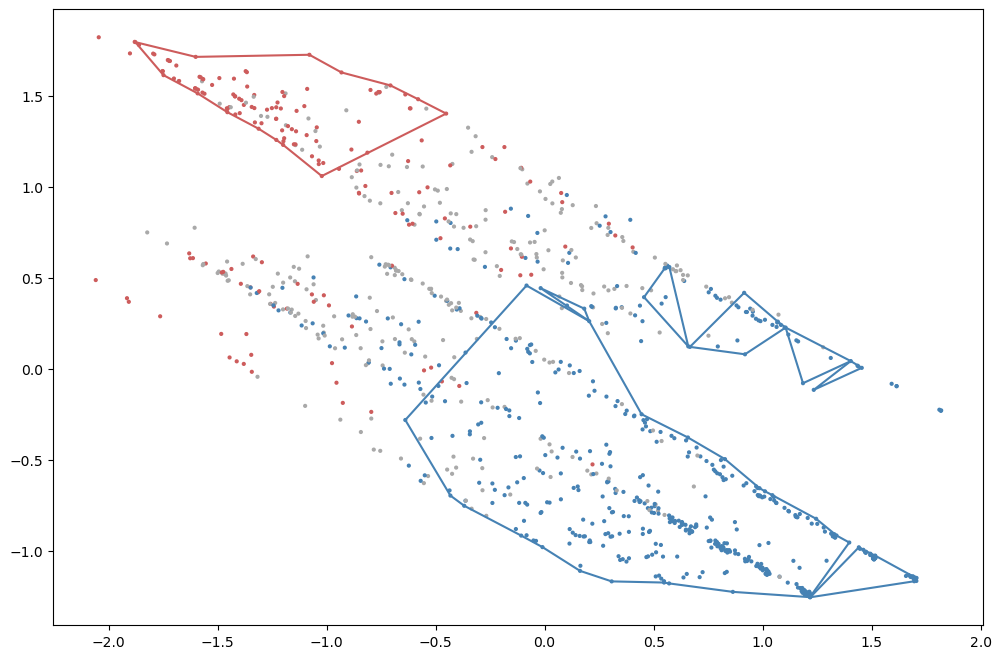

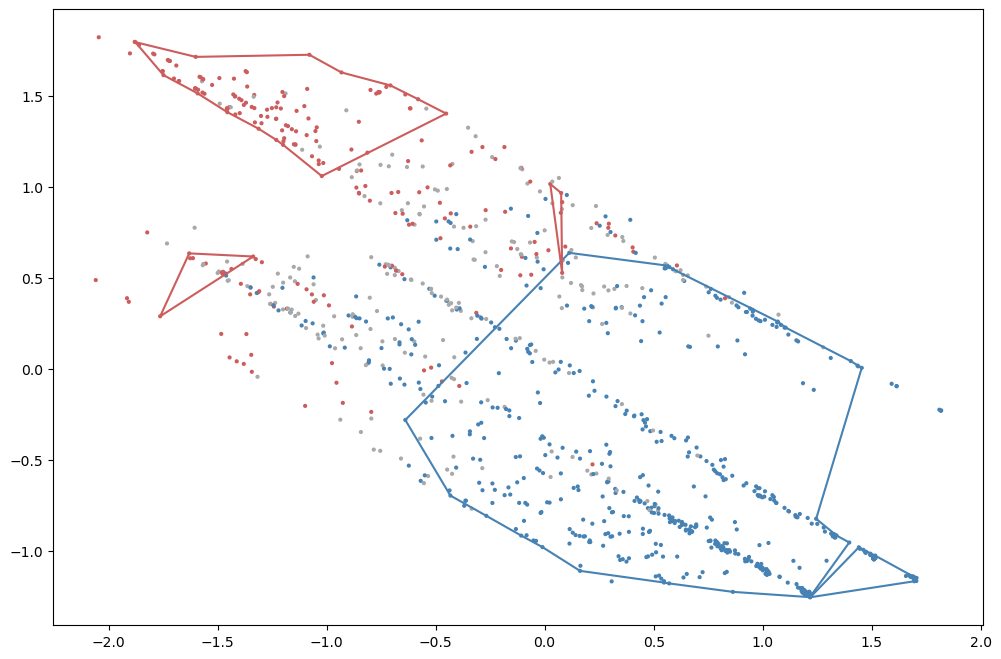

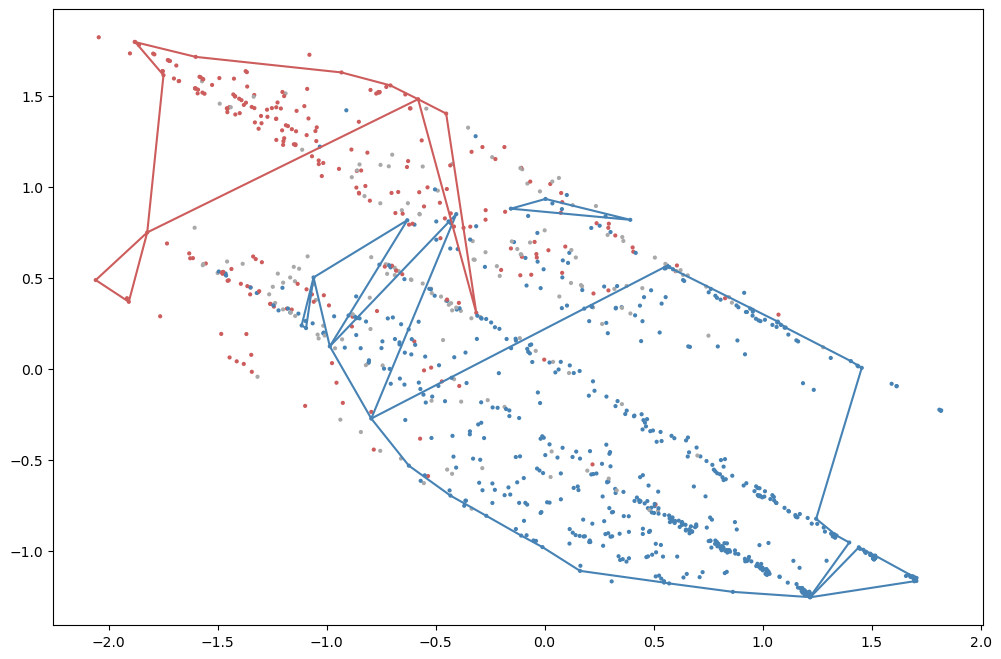

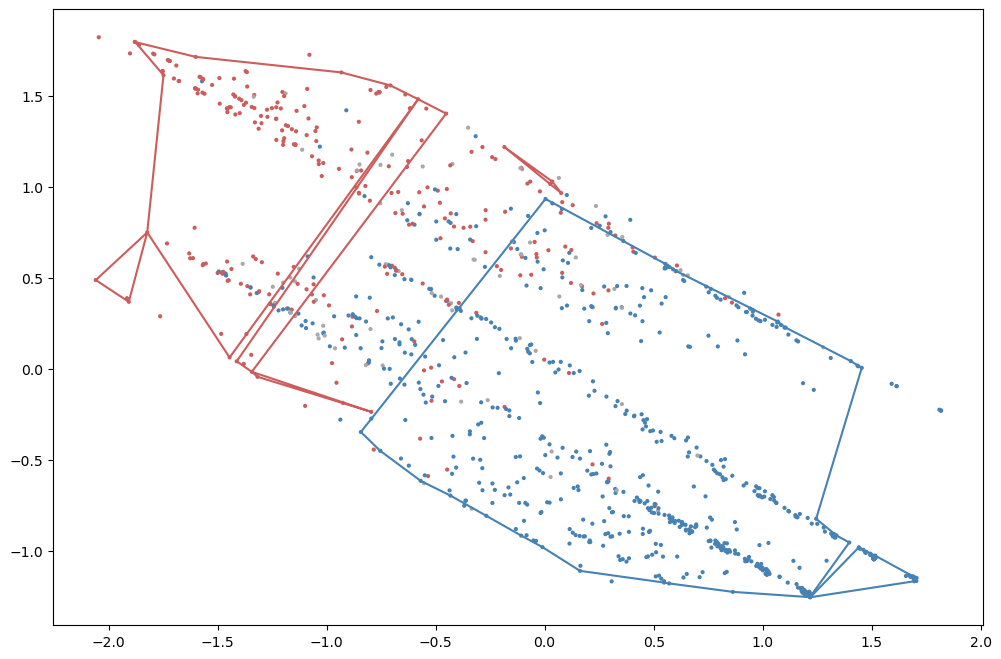

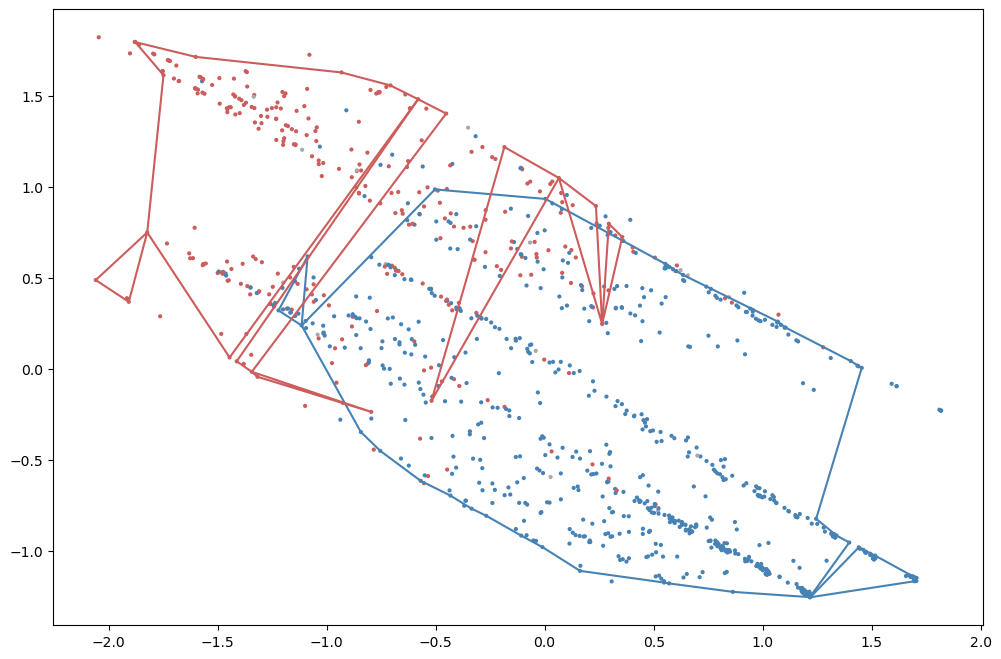

In [26]:
n = 1
fp_metrics = []
path = '/home/files/hospital1/'

for t in T:

    df_ih_tri = pd.cut(df_ih['instance_hardness'], bins=[0,t,(1-t),1], labels=[-1, 0, 1], include_lowest=True)

    #finding footprints
    pi = 0.55
    out_easy = trace_build_wrapper(result.pilot.Z, df_ih_tri.values == -1, pi)
    out_amb = trace_build_wrapper(result.pilot.Z, df_ih_tri.values == 0, pi)
    out_hard = trace_build_wrapper(result.pilot.Z, df_ih_tri.values == 1, pi)
    
    ninst = result.pilot.Z.shape[0]
    space = trace_build_wrapper(result.pilot.Z, np.ones(ninst, dtype=bool), pi)
    
    fp_metrics.append([t, out_easy.area/space.area, out_easy.density/space.density, out_easy.purity,
                   out_amb.area/space.area, out_amb.density/space.density, out_amb.purity,
                   out_hard.area/space.area, out_hard.density/space.density, out_hard.purity])
    
    print(t)
    cmap = ListedColormap(['steelblue', 'darkgrey', 'indianred'])

    plt.figure(figsize=(12, 8))
    plt.scatter(*result.pilot.Z.T, c=df_ih_tri.values, s=4, cmap=cmap)
    plot_poly(out_easy.polygon, 'steelblue')
    plot_poly(out_hard.polygon, 'indianred')
    plt.savefig('hosp' + str(t) + '.pdf', bbox_inches='tight')

    poly = out_hard.polygon 

    print(out_hard)

In [27]:
fp_metrics = pd.DataFrame(np.row_stack(fp_metrics))

fp_metrics.columns =['t','out_easy.area', 'out_easy.density', 'out_easy.purity', 
                  'out_amb.area', 'out_amb.density', 'out_amb.purity',
                  'out_hard.area', 'out_hard.density', 'out_hard.purity']

fp_metrics = round(fp_metrics, 3)
fp_metrics['num'] = (fp_metrics['out_hard.area'] * fp_metrics['out_hard.density'])
fp_metrics['metric'] = (fp_metrics['out_hard.purity'] + fp_metrics['out_easy.purity'])/2
fp_metrics

t  out_easy.area  out_easy.density  out_easy.purity  out_amb.area  \
0   0.300          0.097             2.576            0.809         0.814   
1   0.320          0.096             2.859            0.823         0.697   
2   0.340          0.147             2.340            0.831         0.639   
3   0.360          0.175             2.164            0.871         0.550   
4   0.380          0.219             1.899            0.880         0.551   
5   0.400          0.220             1.951            0.906         0.322   
6   0.420          0.330             1.574            0.892         0.265   
7   0.440          0.477             1.173            0.889         0.002   
8   0.460          0.508             1.169            0.907         0.002   
9   0.480          0.544             1.145            0.900         0.000   
10  0.495          0.656             1.154            0.867         0.000   

    out_amb.density  out_amb.purity  out_hard.area  out_hard.density  \
0             0.844           0.883          0.003             3.616   
1             0.839           0.889          0.008             3.434   
2             0.863           0.844          0.014             2.680   
3             0.859           0.810          0.040             2.013   
4             0.844           0.730          0.045             1.726   
5             0.931           0.707          0.067             1.352   
6             0.995           0.609          0.079             1.381   
7             3.373           1.000          0.090             1.438   
8             3.373           1.000          0.127             0.866   
9             0.000           0.000          0.249             0.752   
10            0.000           0.000          0.296             0.772   

    out_hard.purity       num  metric  
0             0.692  0.010848  0.7505  
1             0.700  0.027472  0.7615  
2             0.789  0.037520  0.8100  
3             0.741  0.080520  0.8060  
4             0.778  0.077670  0.8290  
5             0.832  0.090584  0.8690  
6             0.833  0.109099  0.8625  
7             0.881  0.129420  0.8850  
8             0.904  0.109982  0.9055  
9             0.867  0.187248  0.8835  
10            0.837  0.228512  0.8520

In [29]:
df = fp_metrics[fp_metrics["out_hard.density"] > 0]
area_hosp = list(df['out_hard.area'])
density_hosp = list(df['out_hard.density'])
purity_hosp = list(df['out_hard.purity'])

area_easy_hosp = list(df['out_easy.area'])
density_easy_hosp = list(df['out_easy.density'])
purity_easy_hosp = list(df['out_easy.purity'])

In [36]:
import matplotlib as mpl

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False


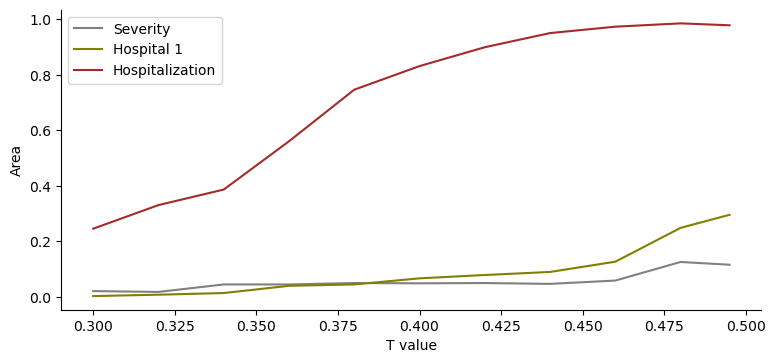

In [40]:
#area
T = list(df['t'])

plt.plot(T, area_gravidade,'gray', label='Severity')
plt.plot(T, area_hosp,'olive', label='Hospital 1')
plt.plot(T, area_dias,'brown', label='Hospitalization')

# naming the x axis
plt.xlabel('T value')
# naming the y axis
plt.ylabel('Area')
plt.legend(loc="best")

plt.show

set_size(7,3)


plt.savefig('footprint_area_hard.pdf')

plt.show()


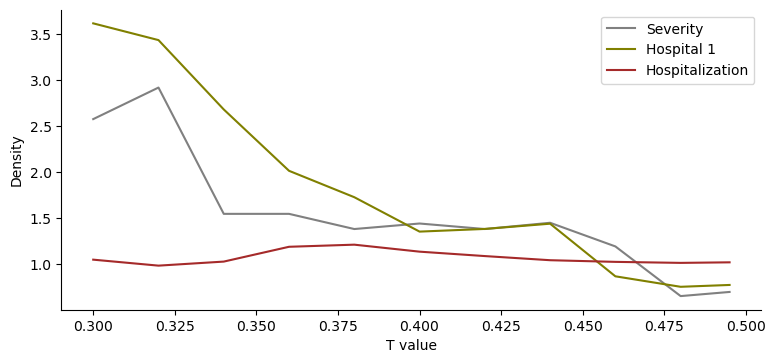

In [41]:
#density
T = list(df['t'])


plt.plot(T, density_gravidade,'gray', label='Severity')
plt.plot(T, density_hosp,'olive', label='Hospital 1')
plt.plot(T, density_dias,'brown', label='Hospitalization')

# naming the x axis
plt.xlabel('T value')
# naming the y axis
plt.ylabel('Density')
plt.legend(loc="best")

plt.show

set_size(7,3)

plt.savefig('footprint_density_hard.pdf')

plt.show()



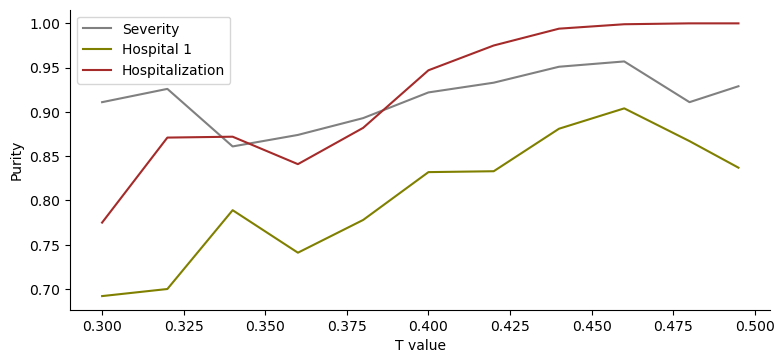

In [42]:
#density
T = list(df['t'])

fig, ax = plt.subplots()

plt.subplots_adjust(left=0.2,bottom=0.2, top = 0.9, right = 0.9)

ax.plot(T, purity_gravidade,'gray', label='Severity')
ax.plot(T, purity_hosp,'olive', label='Hospital 1')
ax.plot(T, purity_dias,'brown', label='Hospitalization')


# naming the x axis
plt.xlabel('T value')
# naming the y axis
plt.ylabel('Purity')

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))

plt.show

set_size(6,3)

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))

# naming the x axis
plt.xlabel('T value')
# naming the y axis
plt.ylabel('Purity')
plt.legend(loc="best")

set_size(6,3)

plt.savefig('footprint_purity_hard.pdf', bbox_inches='tight')

plt.show()
